In [75]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.use("TkCairo")

In [76]:
    
## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
# k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as integ

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

In [77]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
#     'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

In [78]:
sys.path.append('..')
import twosphere_temperature as tst
import pti_model as pti

In [79]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 150,  # to adjust notebook inline plot size
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100,
    'axes.formatter.limits' : [-3, 3]
}
mpl.rcParams.update(params)

## Build a thing to move axis multiplier to label
## https://stackoverflow.com/questions/45760763/how-to-move-the-y-axis-scale-factor-to-the-position-next-to-the-y-axis-label
## -----

# import numpy as np
# import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

class Labeloffset():
    def __init__(self,  ax, label="", axis="y"):
        self.axis = {"y":ax.yaxis, "x":ax.xaxis}[axis]
        self.label=label
        ax.callbacks.connect(axis+'lim_changed', self.update)
        ax.figure.canvas.draw()
        self.update(None)

    def update(self, lim):
        fmt = self.axis.get_major_formatter()
        self.axis.offsetText.set_visible(False)
        self.axis.set_label_text(self.label + " (" + fmt.get_offset() + ")" )

    

Path to temperature dependent dielectric data

In [80]:
path_to_diel_data = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'DMREF',
    'dielectrics'
    )

In [81]:
os.path.exists(path_to_diel_data)

True

#### System parameters

In [82]:
a1 = 10
# eps_back = 1.473**2
eps_back = 1.473**2

plot_hws = np.linspace(1.8, 2.6, 300)

sensorsize_nm = 1000
ergpers_per_watt = 1e7
cm_per_nm = 1e-7

# pump_intensity = pump_power_watts*ergpers_per_watt/(300*cm_per_nm)**2.
## Define field magnitude from intensity in ergs/(cm^2*s)
# E_pump_mag = ((8*np.pi/c)*pump_intensity)**0.5 
# E_pump_mag = (pump_power_watts*ergpers_per_watt)**0.5
## Try Baffou intensity from APL 2009, DOI: 10.1063/1.3116645
pump_intensity_watts_per_cm2 = 1e5/2
pump_power_watts = (
    pump_intensity_watts_per_cm2 * np.pi*(150*cm_per_nm)**2
    )
E_pump_mag = (pump_power_watts*ergpers_per_watt)**0.5

## Define probe intensity
probe_power_watts = 1.1*1e-3 
probe_intensity = (
    probe_power_watts*ergpers_per_watt
    /(300*cm_per_nm)**2.
    )
E_probe_mag = ((8*np.pi/c)*probe_intensity)**0.5

probe_enei = 2.5
# probe_enei = anti_enei
b1 = a1 

## Assign material porperties of gold
# au_eps_inf=9.82335326  # eps_inf
# au_w_p=9.06705560/hbar  # w_p
# au_gamma=0.0334860149/hbar  # gamma
## BEM Drude parameters
au_eps_inf=10  # eps_inf
au_w_p=9.0705/hbar  # w_p
au_gamma=0.0660/hbar  # gamma

kappa_glycerol = 0.292 

m_per_cm = 1e-2
pump_intensity_watts_per_cm2/(m_per_cm)**2

## polarizability I have been using based on some Drude parameters ([probably from BEM])
def alpha_1_of_hw(hw):
    return cp.sparse_Mie_sphere_polarizability_Drude(
        w=hw/hbar, 
        a=a1*1e-7, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )


Load n and k data and convert to epsilon

In [83]:
## Initialize dictionaries to hold the datas
hw_n_T_dict = {}
hw_eps_T_dict = {}

## loop through temperatures to store n&k and calculate epsilon
for i in range(0, 100):
    lambda_n_and_k = np.loadtxt(
        os.path.join(path_to_diel_data, f'au_Conor_{i:d}K.txt'),
        skiprows=3
        )
    ## Data is in DDA format, meaning 
    ## wavelengths in micron, n, k
    lambda_n_and_k[:, 0] *= 1e3 ## nm per micron
    
    n_compl = lambda_n_and_k[:, 1] + 1j*lambda_n_and_k[:, 2]

    ## Assuming epsilon = (n + ik)^2
    hbarw_diel, eps_0K = (
        1240/lambda_n_and_k[:, 0],
        (n_compl)**2.
        )
    
    ## Store data in dictionaries
    hw_eps_T_dict[f'hw_eps_{i:d}K'] = np.vstack((hbarw_diel, eps_0K))
    hw_n_T_dict[f'hw_n_{i:d}K'] = np.vstack((hbarw_diel, n_compl))

## Plot n as a function of T, is it linear as we assumed?

In [84]:
## Get all n data into array to calculate finite difference derivitive

## Real part first
## ---------------
## Initialize array: rows correspond to wavelengths, columns to temperatures
nr_array = np.zeros((
    len(hw_n_T_dict[f'hw_n_0K'][0])+1, 101
    )) 

## use first column and row for labels
nr_array[1:, 0] = hw_n_T_dict[f'hw_n_0K'][0].real
nr_array[0, 1:] = np.linspace(0, 99, 100)

## Populate array with n values from dictionary
for i in range(100):
    nr_array[1:, i+1] = hw_n_T_dict[f'hw_n_{i:d}K'][1].real

## Then Imaginary part
## -------------------
ni_array = np.zeros((
    len(hw_n_T_dict[f'hw_n_0K'][0])+1, 101
    )) 

## use first column and row for labels
ni_array[1:, 0] = hw_n_T_dict[f'hw_n_0K'][0].real
ni_array[0, 1:] = np.linspace(0, 99, 100)

## Populate array with n values from dictionary    
for i in range(100):
    ni_array[1:, i+1] = hw_n_T_dict[f'hw_n_{i:d}K'][1].imag


## Try plotting dn/dt

In [85]:

## Calculate finite difference
dnr_dt_array = np.diff(nr_array[:, 1:], axis=1)
## -------------------


## Calculate finite difference
dni_dt_array = np.diff(ni_array[:, 1:], axis=1)
## -------------------

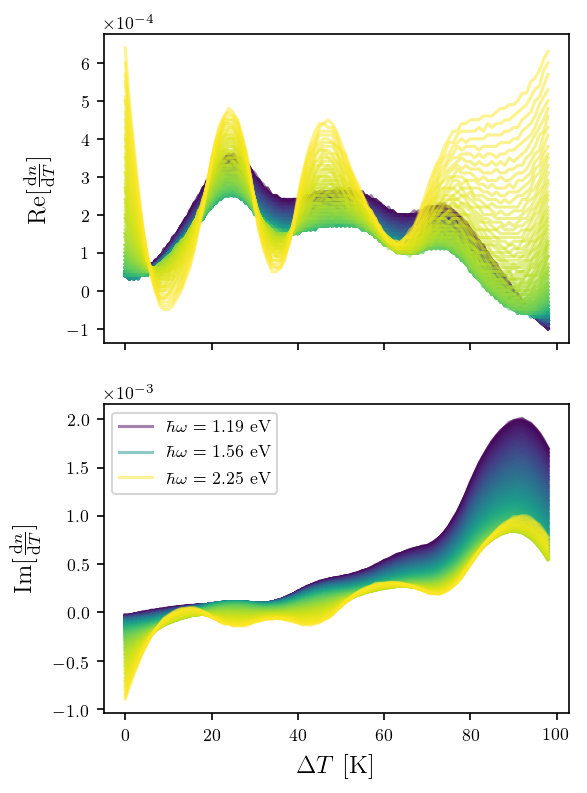

In [97]:
## Build figure
## ------------
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,6))

## Loop through tempertures of Re[n]
for i in range(dnr_dt_array.shape[0]):
    i = dnr_dt_array.shape[0] - i-1
    if i is 0:
        continue
    ## Grab a few frequeny labels for legend
    if ((i == 1) or (i == 145) or (i == 290)):
        label = r'$\hbar\omega = $'+f' {nr_array[i, 0]:.2f} eV'
    else: label=None
    
    axs[0].plot(
        nr_array[0, 1:-1], 
        dnr_dt_array[i], 
        label=label,
        c=mpl.cm.viridis(1-i/296), 
        alpha=.5)

    ## Grab a few frequeny labels for legend
    if ((i == 1) or (i == 145) or (i == 290)):
        label = r'$\hbar\omega = $'+f' {ni_array[i, 0]:.2f} eV'
    else: label=None
        
    axs[1].plot(
        ni_array[0, 1:-1], 
        dni_dt_array[i], 
        c=mpl.cm.viridis(1-i/296), 
        label=label,
        alpha=.5)


axs[0].set_ylabel(r'$\mathrm{Re}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_ylabel(r'$\mathrm{Im}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_xlabel(r'$\Delta T$ [K]')
axs[1].legend()

#### plot dn_dt / n to compare to what I was doing before

## dielectric function 

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


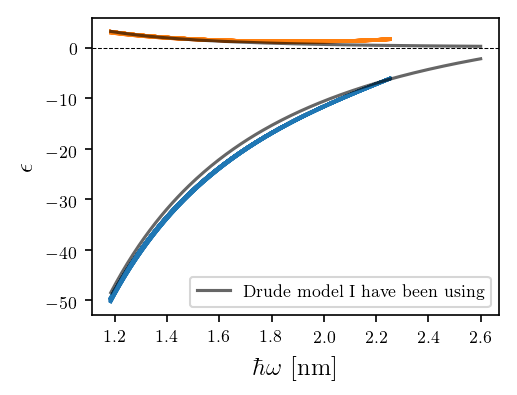

In [59]:
for i in range(100):
    plt.plot(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
        np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), 
        c='C0',  
        alpha=i/100,
        )
    plt.plot(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
        np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), 
        c='C1',  
        alpha=i/100
        )
    
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\hbar\omega$ [nm]')

hw_h = np.linspace(hw_eps_T_dict[f'hw_eps_{i:d}K'][0].min(), 2.6, 200)

drude_model = cp.drude_model(hw_h/hbar, eps_inf=au_eps_inf, w_p=au_w_p, gamma=au_gamma)

plt.plot(
    hw_h,
    np.real(drude_model),
    c = 'k',
    label='Drude model I have been using',
    alpha=.6
    )
plt.plot(
    hw_h,
    np.imag(drude_model),
    c = 'k',
    alpha=.6
    )

plt.axhline(0, lw=.5, ls='--', c='k')
plt.legend()

## Fit Drude Lorentz Model

In [60]:
fit_cutoff = 2.

def drude_lorentz_cost(param, *args):

    eps_inf, w_p, gamma, f1, w1 = param
    
    hw, data = args
    
    model = cp.drude_lorentz_model(
        hw/hbar, 
        eps_inf=eps_inf, 
        w_p=w_p, 
        gamma=gamma,
        f_1 = f1,
        w_1 = w1)

    res = (model - data)*(
        hw**10.
#         1
#         >fit_cutoff
        )
    
    return np.array([res.real, res.imag]).ravel()
    

In [61]:
## Fit temperature dependent dielectric function seperately at 
## each temperature.
ini_params = [au_eps_inf, au_w_p, au_gamma, 0, 1e16]

temp_dep_eps_fits = {}
for i in range(100):
    temp_dep_eps_fits[f'{i:d}K'] = opt.least_squares(
        drude_lorentz_cost,
        ini_params,
        args=(hw_eps_T_dict[f'hw_eps_0K'][0], hw_eps_T_dict[f'hw_eps_{i:d}K'][1]),
        x_scale=[1e2, 1e16, 1e14, 1, 1e16]
        )
    ini_params = temp_dep_eps_fits[f'{i:d}K']['x']

In [62]:
## Generate the polarizabilies from the fit Drude parameters 
## for every temperature.

## First, define the energy axis
hws = np.linspace(hw_eps_T_dict[f'hw_eps_0K'][0].min(), 2.4, 200)

fit_alpha_of_T = {}
fit_alpha_of_T['hw'] = hws
## Make some plots
for i in range(100):

    fit_drude = cp.drude_lorentz_model(
        hws/hbar, 
        *temp_dep_eps_fits[f'{i:d}K']['x']
        )
    ## Build polarizability from 0K data
    fit_alpha_of_T[f'{i:d}K'] =  cp.sparse_sphere_polarizability_Mie(
        fit_drude,
        eps_b=eps_back,
        a=a1*1e-7,
        w=hws/hbar,
        )[:, 0,0]

In [63]:
hws[np.argmax(fit_alpha_of_T['0K'].imag)]

(2.2839100007293918+0j)

## Compute dn/dT from DL fit

In [64]:
nr_array = np.zeros((len(hws), 100))
ni_array = np.zeros((len(hws), 100))

for i in range(100):
    
    fit_eps = cp.drude_lorentz_model(
        hws/hbar, 
        *temp_dep_eps_fits[f'{i:d}K']['x']
        )
    nr_array[:, i] = np.sqrt( (np.abs(fit_eps) + fit_eps.real)/2)
    ni_array[:, i] = np.sqrt( (np.abs(fit_eps) - fit_eps.real)/2)


In [65]:

## Calculate finite difference
dnr_dt_array = np.diff(nr_array, axis=1)
## -------------------

## Calculate finite difference
dni_dt_array = np.diff(ni_array, axis=1)
## -------------------

In [66]:
dni_dt_array.shape

(200, 99)

In [67]:
np.argwhere(np.round(hws, decimals=2)==2.25)

array([[174],
       [175]])

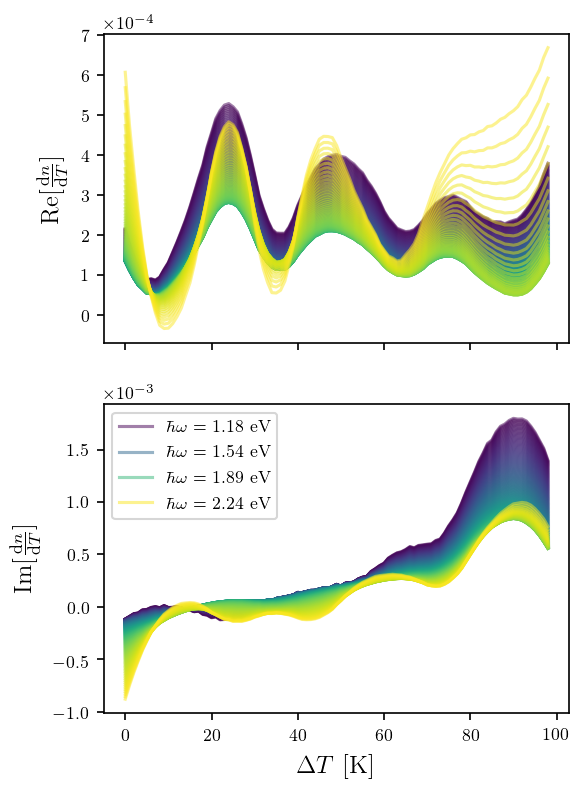

In [74]:
## Build figure
## ------------
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,6))

## Loop through tempertures of Re[n]
max_freq = 2.25
max_idx = np.argwhere(np.round(hws, decimals=2)==max_freq).ravel()[0]
min_idx=0
for i in range(max_idx):
    ## Grab a few frequeny labels for legend
    if (
        (i == round(min_idx+(max_idx-min_idx)*0/3)) 
        or 
        (i == round(min_idx+(max_idx-min_idx)*1/3)) 
        or 
        (i == round((min_idx+(max_idx-min_idx)*2/3)))
        or
        (i == round((min_idx+(max_idx-min_idx)*3/3-1)))
        ):
        label = r'$\hbar\omega = $'+f' {hws[i].real:.2f} eV'
    else: label=None
    
    axs[0].plot(
        np.arange(99), 
        dnr_dt_array[i], 
        label=label,
        c=mpl.cm.viridis(i/max_idx), 
        alpha=.5)

    axs[1].plot(
        np.arange(99), 
        dni_dt_array[i], 
        c=mpl.cm.viridis(i/max_idx), 
        label=label,
        alpha=.5)


axs[0].set_ylabel(r'$\mathrm{Re}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_ylabel(r'$\mathrm{Im}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_xlabel(r'$\Delta T$ [K]')
axs[1].legend()

In [70]:
max_idx

199

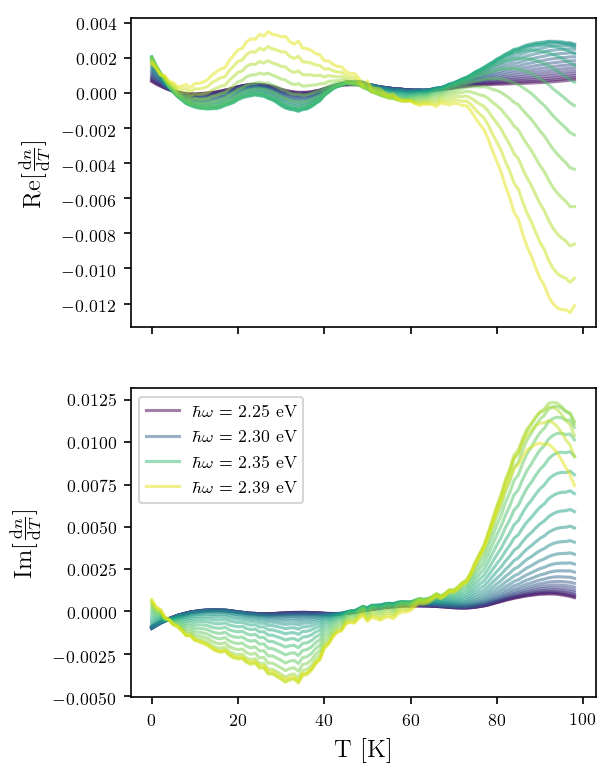

In [69]:
## Build figure
## ------------
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,6))

## Loop through tempertures of Re[n]
min_freq = 2.25
min_idx = np.argwhere(np.round(hws, decimals=2)==min_freq).ravel()[0]

max_freq = 2.6
try:
    max_idx = np.argwhere(np.round(hws, decimals=2)==max_freq).ravel()[0]
except IndexError:
    max_idx = len(hws)-1
for i in range(min_idx, max_idx):

    ## Grab a few frequeny labels for legend
    if (
        (i == round(min_idx+(max_idx-min_idx)*0/3)) 
        or 
        (i == round(min_idx+(max_idx-min_idx)*1/3)) 
        or 
        (i == round((min_idx+(max_idx-min_idx)*2/3)))
        or
        (i == round((min_idx+(max_idx-min_idx)*3/3-1)))
        ):
        label = r'$\hbar\omega = $'+f' {hws[i].real:.2f} eV'
    else: label=None
    
    axs[0].plot(
        np.arange(99), 
        dnr_dt_array[i], 
        label=label,
        c=mpl.cm.viridis((i-min_idx)/(max_idx-min_idx)), 
        alpha=.5)

    axs[1].plot(
        np.arange(99), 
        dni_dt_array[i], 
        c=mpl.cm.viridis((i-min_idx)/(max_idx-min_idx)), 
        label=label,
        alpha=.5)


axs[0].set_ylabel(r'$\mathrm{Re}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_ylabel(r'$\mathrm{Im}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_xlabel('T [K]')
axs[1].legend()

## Compare different frequencies

In [24]:
def idx_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [25]:
def dndt_at_hw(hw, T):
    hw_idx = np.argmin(np.abs(hw_eps_T_dict[f'hw_eps_0K'][0] - hw))
    T_idx = T
    return dnr_dt_array[hw_idx+1, T_idx] + 1j*dni_dt_array[hw_idx+1, T_idx]

 For hw = 2.25,
dnr_dt=0.0003923793983331425,
dni_dt=0.0001899265289164731,
 For hw = 2.15,
dnr_dt=0.0003412587928002808,
dni_dt=0.00019424003010382052,
 For hw = 2.05,
dnr_dt=0.00030105239872263434,
dni_dt=0.0001966556698747013,


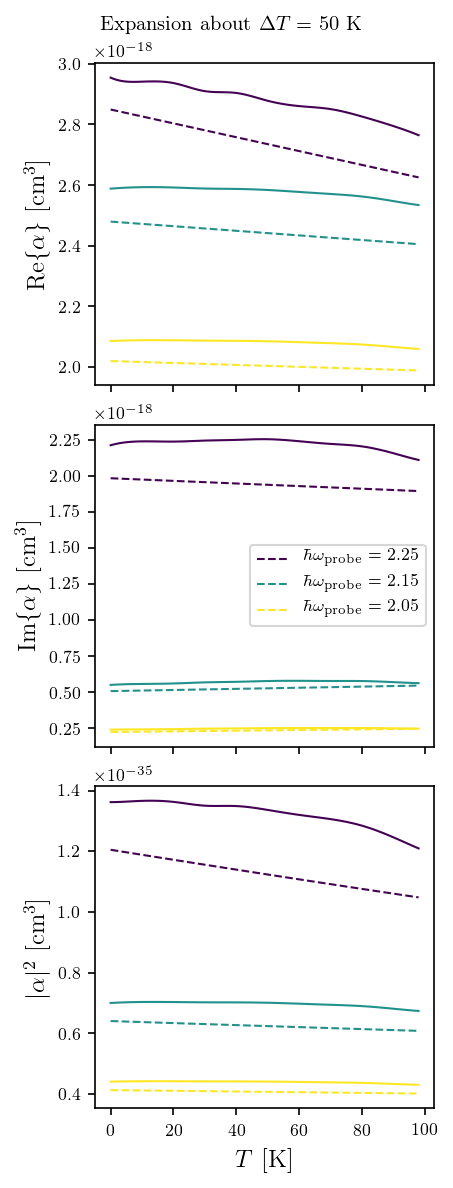

In [26]:
def plot_data_vs_model_at(hw, temp_exp_ab, color_idx, axs):
    
    alpha_mie_epsdata = np.zeros(99, dtype='complex' )
    alpha_drude = np.zeros_like(alpha_mie_epsdata)
    Ts = np.linspace(0, 98, 99)

    for i in range(99):

        ## Get alpha at highest energy from Drude fit
        alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
            cp.drude_lorentz_model(
                hw/hbar, 
                *temp_dep_eps_fits[f'{i:d}K']['x']
                ),
            eps_b=eps_back,
            a=a1*1e-7,
            w=hw/hbar,
            )[ 0,0]

        ## Build model polarizability from expansion about specified temperature
        heated_particle = pti.single_particle_image(
            hw, 
            eps_inf=temp_dep_eps_fits[f'{temp_exp_ab:d}K']['x'][0],  # eps_inf
            w_p=temp_dep_eps_fits[f'{temp_exp_ab:d}K']['x'][1],  # w_p
            gamma=temp_dep_eps_fits[f'{temp_exp_ab:d}K']['x'][2],  # gamma
            E_probe=E_probe_mag,
            eps0=eps_back,
            dielectric_model='DL',
            f_1=temp_dep_eps_fits[f'{temp_exp_ab:d}K']['x'][3],
            w_1=temp_dep_eps_fits[f'{temp_exp_ab:d}K']['x'][4])
        
        alpha_drude[i] = heated_particle.alpha_of_T(
            i, 
            b1*1e-7, 
            a1*1e-7,
            dnr_dt=dndt_at_hw(hw, temp_exp_ab).real,
            dni_dt=dndt_at_hw(hw, temp_exp_ab).imag)

    print(f" For hw = {hw},")
    print(f"dnr_dt={dndt_at_hw(hw, temp_exp_ab).real},")
    print(f"dni_dt={dndt_at_hw(hw, temp_exp_ab).imag},")
    axs[0].plot(
        Ts, 
        np.real(alpha_mie_epsdata), 
        lw=1,    
    #     label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
        c=mpl.cm.viridis(color_idx),  
        )
    axs[1].plot(
        Ts, 
        np.imag(alpha_mie_epsdata), 
        lw=1,
        c=mpl.cm.viridis(color_idx),
        )
    axs[2].plot(
        Ts, 
        np.abs(alpha_mie_epsdata)**2, 
        lw=1,
        c=mpl.cm.viridis(color_idx),
        )

    axs[0].plot(
        Ts, 
        np.real(alpha_drude), 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        ls='--',
    #     label=r'linear $\alpha(T)|_{T=T_R}$',
        c=mpl.cm.viridis(color_idx),  
        )
    axs[1].plot(
        Ts, 
        np.imag(alpha_drude), 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        c=mpl.cm.viridis(color_idx),  
        ls='--',
        )
    axs[2].plot(
        Ts, 
        np.abs(alpha_drude)**2, 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        c=mpl.cm.viridis(color_idx),  
        ls='--',
        )

    
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3,8))

temp = 50

plot_data_vs_model_at(hw=2.25, temp_exp_ab=temp, color_idx=0/2, axs=axs)
plot_data_vs_model_at(hw=2.15, temp_exp_ab=temp, color_idx=1/2, axs=axs)
plot_data_vs_model_at(hw=2.05, temp_exp_ab=temp, color_idx=2/2, axs=axs)
  
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
# # axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
# lo = Labeloffset(axs[0], label=r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$', axis="y")
# axs[0].yaxis.offsetText.set_visible(False)
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[2].set_ylabel(r'$|\alpha|^2$ $[\mathrm{cm}^3]$')

# axs[2, 1].set_xlabel(r'$T$ [K]')
axs[2].set_xlabel(r'$T$ [K]')

axs[1].legend()
# fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}, or {1240/hw.real:.0f} [nm]')

fig.suptitle(f'Expansion about '+r'$\Delta T =$'+f' {temp:d} K')
plt.tight_layout()
plt.subplots_adjust(top=0.94)

 For hw = 2.25,
dnr_dt=0.0002130731546312603,
dni_dt=-0.00011810560947278503,
 For hw = 2.15,
dnr_dt=0.0001873798251524894,
dni_dt=-0.00012391931177990756,
 For hw = 2.05,
dnr_dt=0.00016765713500516144,
dni_dt=-0.00013345851967816458,


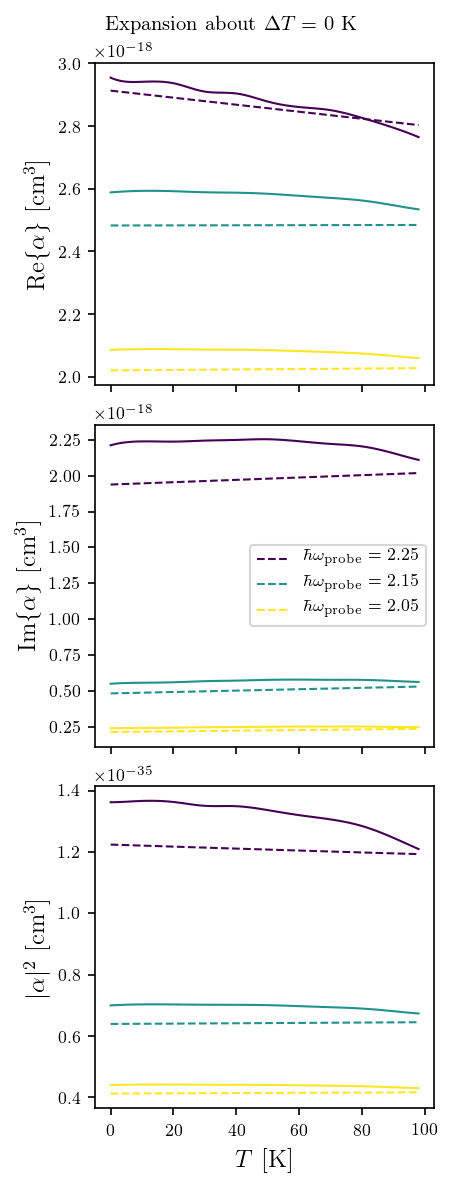

In [27]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3,8))

temp = 0

plot_data_vs_model_at(hw=2.25, temp_exp_ab=temp, color_idx=0/2, axs=axs)
plot_data_vs_model_at(hw=2.15, temp_exp_ab=temp, color_idx=1/2, axs=axs)
plot_data_vs_model_at(hw=2.05, temp_exp_ab=temp, color_idx=2/2, axs=axs)

fig.suptitle(r'$\Delta T$'+ f' {temp:d} K')

  
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
# # axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
# lo = Labeloffset(axs[0], label=r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$', axis="y")
# axs[0].yaxis.offsetText.set_visible(False)
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[2].set_ylabel(r'$|\alpha|^2$ $[\mathrm{cm}^3]$')

# axs[2, 1].set_xlabel(r'$T$ [K]')
axs[2].set_xlabel(r'$T$ [K]')

axs[1].legend()
# fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}, or {1240/hw.real:.0f} [nm]')

fig.suptitle(f'Expansion about '+r'$\Delta T =$'+f' {temp:d} K')

plt.tight_layout()
plt.subplots_adjust(top=0.94)

 For hw = 2.4,
dnr_dt=0.0003923793983331425,
dni_dt=0.0001899265289164731,
 For hw = 2.35,
dnr_dt=0.0003923793983331425,
dni_dt=0.0001899265289164731,
 For hw = 2.25,
dnr_dt=0.0003923793983331425,
dni_dt=0.0001899265289164731,
 For hw = 2.15,
dnr_dt=0.0003412587928002808,
dni_dt=0.00019424003010382052,
 For hw = 2.05,
dnr_dt=0.00030105239872263434,
dni_dt=0.0001966556698747013,


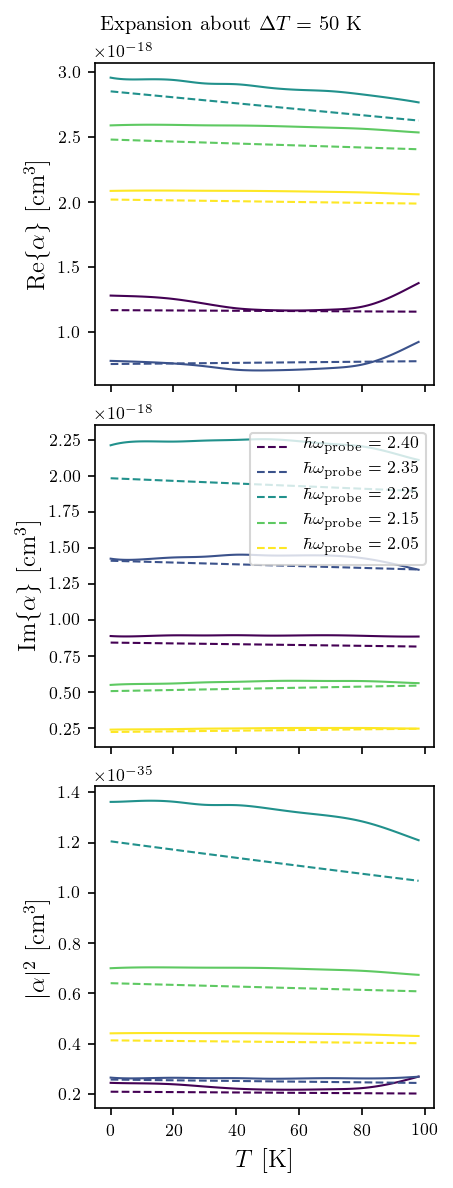

In [28]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3,8))


temp = 50

plot_data_vs_model_at(hw=2.40, temp_exp_ab=temp, color_idx=0/4, axs=axs)    
plot_data_vs_model_at(hw=2.35, temp_exp_ab=temp, color_idx=1/4, axs=axs)
plot_data_vs_model_at(hw=2.25, temp_exp_ab=temp, color_idx=2/4, axs=axs)
plot_data_vs_model_at(hw=2.15, temp_exp_ab=temp, color_idx=3/4, axs=axs)
plot_data_vs_model_at(hw=2.05, temp_exp_ab=temp, color_idx=4/4, axs=axs)

  
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
# # axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
# lo = Labeloffset(axs[0], label=r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$', axis="y")
# axs[0].yaxis.offsetText.set_visible(False)
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[2].set_ylabel(r'$|\alpha|^2$ $[\mathrm{cm}^3]$')

# axs[2, 1].set_xlabel(r'$T$ [K]')
axs[2].set_xlabel(r'$T$ [K]')

axs[1].legend()
# fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}, or {1240/hw.real:.0f} [nm]')

fig.suptitle(f'Expansion about '+r'$\Delta T =$'+f' {temp:d} K')

plt.tight_layout()
plt.subplots_adjust(top=0.94)

 For hw = 2.4,
dnr_dt=0.0002130731546312603,
dni_dt=-0.00011810560947278503,
 For hw = 2.35,
dnr_dt=0.0002130731546312603,
dni_dt=-0.00011810560947278503,
 For hw = 2.25,
dnr_dt=0.0002130731546312603,
dni_dt=-0.00011810560947278503,
 For hw = 2.15,
dnr_dt=0.0001873798251524894,
dni_dt=-0.00012391931177990756,
 For hw = 2.05,
dnr_dt=0.00016765713500516144,
dni_dt=-0.00013345851967816458,


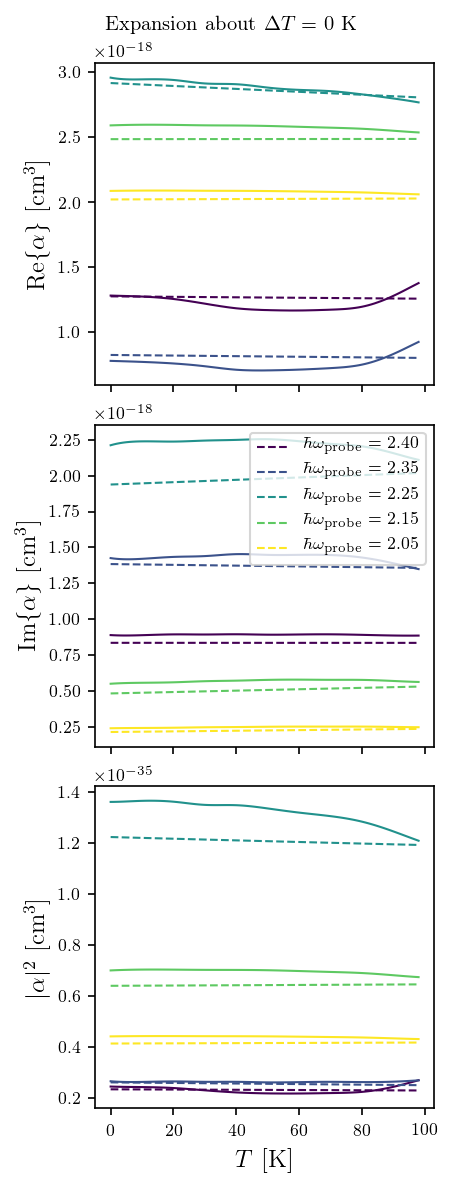

In [29]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3,8))


temp = 0
plot_data_vs_model_at(hw=2.40, temp_exp_ab=temp, color_idx=0/4, axs=axs)    
plot_data_vs_model_at(hw=2.35, temp_exp_ab=temp, color_idx=1/4, axs=axs)
plot_data_vs_model_at(hw=2.25, temp_exp_ab=temp, color_idx=2/4, axs=axs)
plot_data_vs_model_at(hw=2.15, temp_exp_ab=temp, color_idx=3/4, axs=axs)
plot_data_vs_model_at(hw=2.05, temp_exp_ab=temp, color_idx=4/4, axs=axs)

  
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
# # axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
# lo = Labeloffset(axs[0], label=r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$', axis="y")
# axs[0].yaxis.offsetText.set_visible(False)
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[2].set_ylabel(r'$|\alpha|^2$ $[\mathrm{cm}^3]$')

# axs[2, 1].set_xlabel(r'$T$ [K]')
axs[2].set_xlabel(r'$T$ [K]')

axs[1].legend()
# fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}, or {1240/hw.real:.0f} [nm]')
fig.suptitle(f'Expansion about '+r'$\Delta T =$'+f' {temp:d} K')
plt.tight_layout()
plt.subplots_adjust(top=0.94)

### Plot contributions to linear model with thermal radius dependence

In [30]:

dndT_at_0K = dnr_dt_array[1:, 0] + 1j*dni_dt_array[1:, 0]

## Compare to Link's small focal spot

In [31]:
def alpha_0(eps_c, eps_b, a, b, r_th, dndT_c):
    """ eps_c and dndT should be functions of frequency"""
        
    alpha = (
        6*a**3. 
        *
        (eps_b/(eps_c+2*eps_b)**2.)
        *
        eps_c**0.5
        *
        dndT_c
        *
        (1/(np.pi*a))
        *
        ((r_th+a)/r_th)
        *
        (1/(
            ((r_th+a)/r_th)**2.
            +
            (a/r_th)**2.
            ))
        )
    return alpha
    
def alpha_pion2(eps_c, eps_b, a, b, r_th, dndT_c):
    """ eps_c and dndT should be functions of frequency"""
    
    dndT_b = -2.7*10**(-4)
    
    alpha = ((
        6*a**3. 
        *
        eps_b/(eps_c+2*eps_b)**2.
        *
        eps_c**0.5
        *
        dndT_c
        *
        (1/(np.pi*a))
        *
        ((r_th+a)/r_th)
        *
        (1/(
            ((r_th+a)/r_th)**2.
            +
            (a/r_th)**2.)
            )
        )
        +
        ((
            1
            + 
            ((2*a**3./b**3.)
            *
            (eps_c - eps_b)**2./(eps_c+2*eps_b)**2.))
        *
        eps_b**(-0.5)
        *
        dndT_b
        *
        r_th**2.
        ))
    return alpha

def alpha_phi(eps_c, eps_b, a, b, r_th, dndT_c):
    """ eps_c and dndT should be functions of frequency"""
    
    dndT_b = -2.7*10**(-4)
    
    alpha = (
        (
            1+ (2*a**3./b**3.
            *
            (eps_c - eps_b)**2./(eps_c+2*eps_b)**2.))
        *
        eps_b**(-0.5)
        *
        dndT_b
        *
        (-np.exp(-(b-a)/r_th)/(
            ((r_th+a)/r_th)**2.
            +
            (a/r_th)**2.
            ))
        *
        r_th*(b-a)
        )
    return alpha
    
def alpha_pion2phi(eps_c, eps_b, a, b, r_th, dndT_c):
    """ eps_c and dndT should be functions of frequency"""
    
    dndT_b = -2.7*10**(-4)
    
    alpha = (
        (
            1 
            + 
            (
                (2*a**3./b**3.)
                *
                (eps_c - eps_b)**2.
                /
                (eps_c+2*eps_b)**2.
                )
            )
        *
        eps_b**(-0.5)
        *
        dndT_b
        *
        (
            -np.exp(-(b-a)/r_th)
            /
            (
                ((r_th+a)/r_th)**2.
                +
                (a/r_th)**2.
                )
            )
        *
        (
            r_th*(b+r_th)
            +
            a*(2*b+r_th)
            )
        )
    return alpha

In [32]:

def build_mag_plots(T_expansion, r_th, w0):
    ## Get dielectric function and dn/dT
    fit_drude = cp.drude_lorentz_model(
            hws/hbar, 
            *temp_dep_eps_fits[f'{T_expansion:d}K']['x']
            )
    fit_dndT = dnr_dt_array[:, T_expansion] + 1j*dni_dt_array[:, T_expansion]

    plt.plot(
        hws.real,
        alpha_0(fit_drude, eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT).real,
        label=r"$\alpha_\Omega^{(0)}$")
    plt.plot(
        hws.real,
        alpha_pion2(fit_drude, eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT).real,
        label=r"$\alpha_\Omega^{\pi/2}$",
        ls='--')
    plt.plot(
        hws.real,
        alpha_phi(fit_drude, eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT).real,
        label=r"$\alpha_\Omega^{(\phi_{w_0})}$")
    plt.plot(
        hws.real,
        alpha_pion2phi(fit_drude, eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT).real,
        label=r"$\alpha_\Omega^{(\pi/2+\phi_{w_0})}$",
        ls='--')
    plt.legend()
    plt.ylabel(r'$\mathrm{Re}[\alpha]$')
    plt.xlabel(r'$\hbar\omega$')
    plt.title(r' $w_0 =$'+f' {round(w0*1e7):d} [nm]')


    plt.figure()
    plt.plot(
        hws.real,
        alpha_0(fit_drude, eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT).imag,
        label=r"$\alpha_\Omega^{(0)}$")
    plt.plot(
        hws.real,
        alpha_pion2(fit_drude, eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT).imag,
        label=r"$\alpha_\Omega^{(\pi/2)}$",
        ls='--')
    plt.plot(
        hws.real,
        alpha_phi(fit_drude, eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT).imag,
        label=r"$\alpha_\Omega^{(\phi_{r_\mathrm{th}})}$")
    plt.plot(
        hws.real,
        alpha_pion2phi(fit_drude, eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT).imag,
        label=r"$\alpha_\Omega^{(\pi/2+\phi_{r_\mathrm{th}})}$",
        ls='--')
    plt.legend()
    plt.ylabel(r'$\mathrm{Im}[\alpha]$')
    plt.xlabel(r'$\hbar\omega$')
    plt.title(r' $w_0 =$'+f' {round(w0*1e7):d} [nm]')

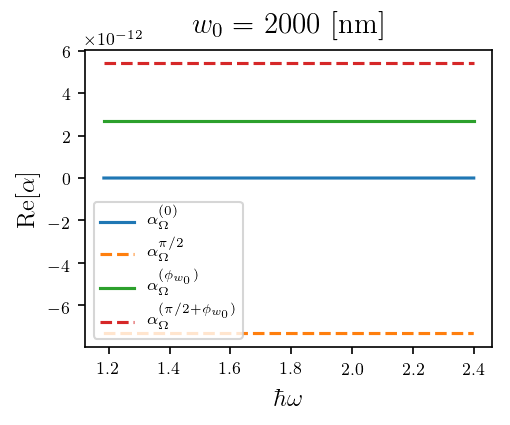

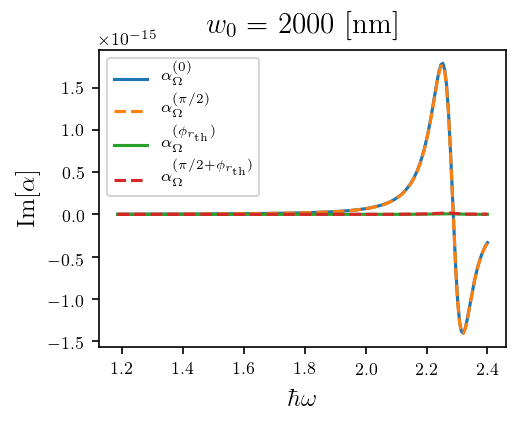

In [33]:
## w0 = r_th

T_expansion = 0

a = 10e-7
r_th = 2e-4

w0 = r_th

    
build_mag_plots(T_expansion=T_expansion, r_th=r_th, w0=w0)

In [36]:
def build_phase_plots(hw, w0, r_th):
    phis = np.linspace(0, 2*np.pi, 100)
    
    fit_drude = cp.drude_lorentz_model(
        hws/hbar, 
        *temp_dep_eps_fits[f'{T_expansion:d}K']['x']
        )
    fit_dndT = dnr_dt_array[:, T_expansion] + 1j*dni_dt_array[:, T_expansion]

    plt.plot(
        phis,
        np.cos(phis) * alpha_0(fit_drude[idx_nearest(hws, hw)], eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT[idx_nearest(hws, hw)]).real,
        label=r"$\alpha_\Omega^{(0)}\cos(\phi)$")
    plt.plot(
        phis,
        np.sin(phis) * alpha_pion2(fit_drude[idx_nearest(hws, hw)], eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT[idx_nearest(hws, hw)]).real,
        label=r"$\alpha_\Omega^{(\pi/2)}\sin(\phi)$",
        ls='--')
    plt.plot(
        phis,
        np.cos(phis- (w0-a)/r_th) * alpha_phi(fit_drude[idx_nearest(hws, hw)], eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT[idx_nearest(hws, hw)]).real,
        label=r"$\alpha_\Omega^{(\phi_{w_0})}\cos(\phi-\frac{w_0-a}{r_\mathrm{th}})$")
    plt.plot(
        phis,
        np.sin(phis - (w0-a)/r_th) * alpha_pion2phi(fit_drude[idx_nearest(hws, hw)], eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT[idx_nearest(hws, hw)]).real,
        label=r"$\alpha_\Omega^{(\pi/2+\phi_{w_0})}\sin(\phi-\frac{w_0-a}{r_\mathrm{th}})$")
    plt.legend(fontsize=6)
    plt.ylabel(r'$\mathrm{Re}[\alpha]$')
    plt.xlabel(r'$\phi$')
    plt.title(r'$\hbar\omega =$'+f' {hw:.2f} [eV],'+r' $w_0 =$'+f' {round(w0*1e7):d} [nm]')


    ## Imaginary part
    plt.figure()
    plt.plot(
        phis,
        np.cos(phis) * alpha_0(fit_drude[idx_nearest(hws, hw)], eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT[idx_nearest(hws, hw)]).imag,
        label=r"$\alpha_\Omega^{(0)}\cos(\phi)$")
    plt.plot(
        phis,
        np.sin(phis) * alpha_pion2(fit_drude[idx_nearest(hws, hw)], eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT[idx_nearest(hws, hw)]).imag,
        label=r"$\alpha_\Omega^{(\pi/2)}\sin(\phi)$",
        ls='--')
    plt.plot(
        phis,
        np.cos(phis - (w0-a)/r_th) * alpha_phi(fit_drude[idx_nearest(hws, hw)], eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT[idx_nearest(hws, hw)]).imag,
        label=r"$\alpha_\Omega^{(\phi_{w_0})}\cos(\phi-\frac{w_0-a}{r_\mathrm{th}})$")
    plt.plot(
        phis,
        np.sin(phis - (w0-a)/r_th) * alpha_pion2phi(fit_drude[idx_nearest(hws, hw)], eps_back, a=a, b=w0, r_th=r_th, dndT_c=fit_dndT[idx_nearest(hws, hw)]).imag,
        label=r"$\alpha_\Omega^{(\pi/2+\phi_{w_0})}\sin(\phi-\frac{w_0-a}{r_\mathrm{th}})$")
    plt.legend(fontsize=6)
    plt.ylabel(r'$\mathrm{Im}[\alpha]$')
    plt.xlabel(r'$\phi$')
    plt.title(r'$\hbar\omega =$'+f' {hw:.2f} [eV],'+r' $w_0 =$'+f' {round(w0*1e7):d} [nm]')

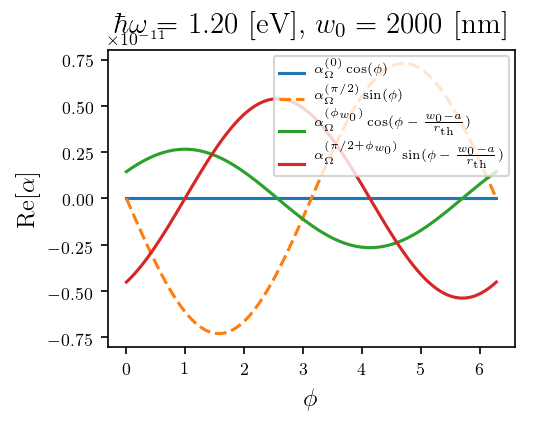

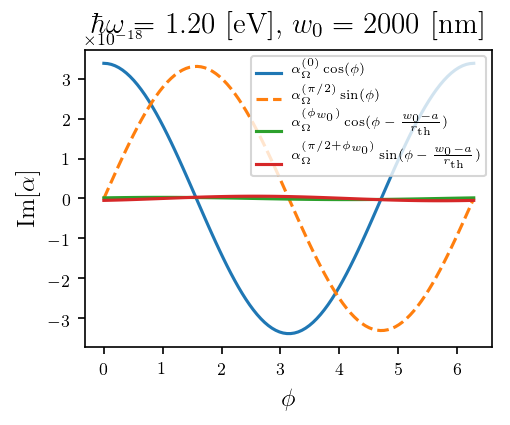

In [37]:
hw = 1.2 

build_phase_plots(hw, w0, r_th)

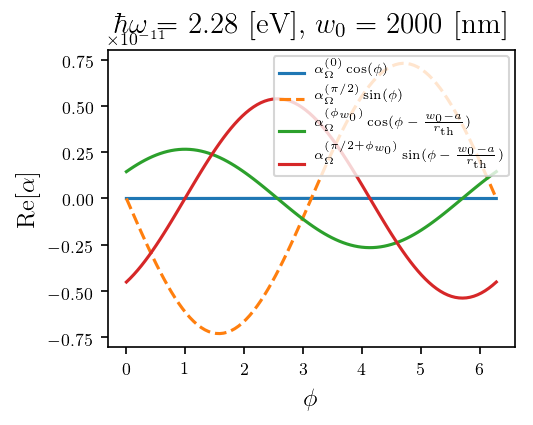

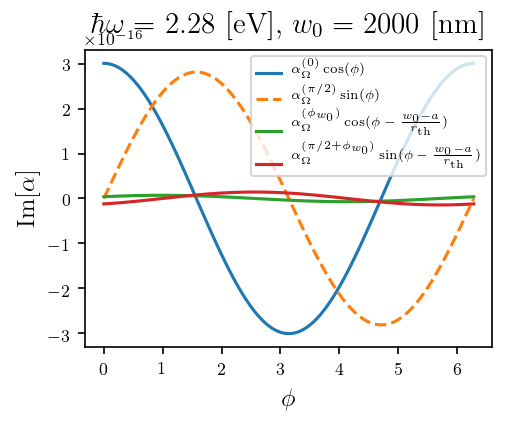

In [38]:
hw = 2.284

build_phase_plots(hw, w0, r_th)

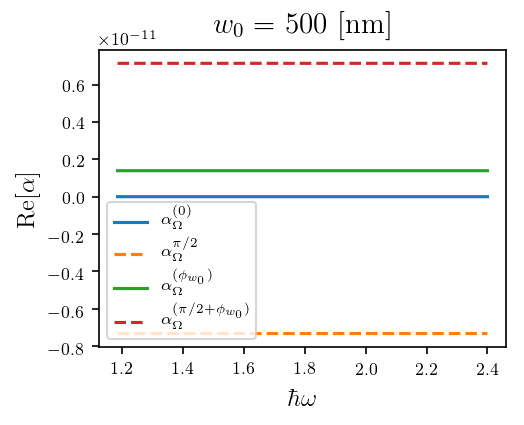

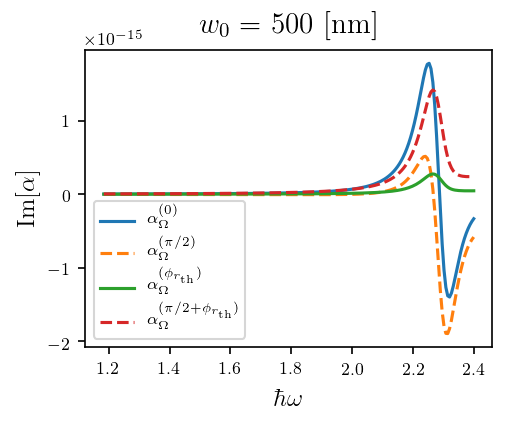

In [39]:
w0 = 500*1e-7

T_expansion = 0

a = 10e-7
r_th = 2e-4

build_mag_plots(T_expansion=T_expansion, r_th=r_th, w0=w0)

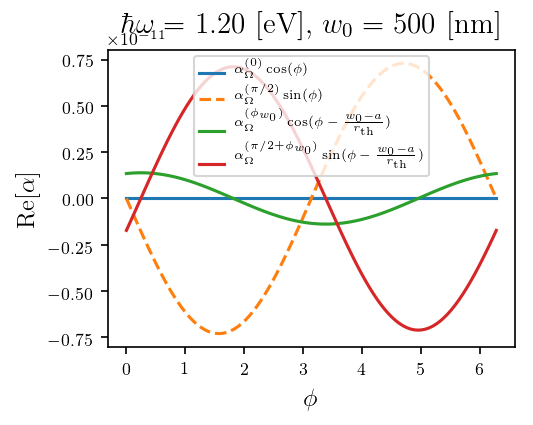

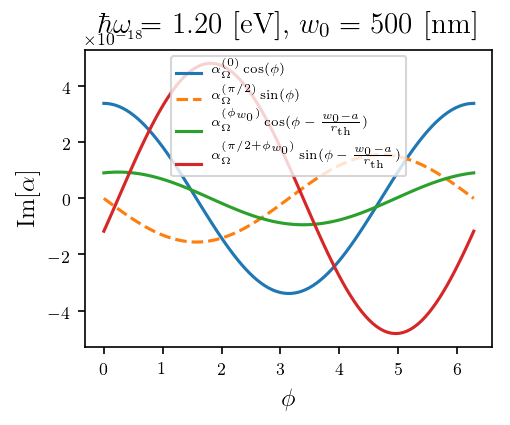

In [40]:
hw = 1.2 

build_phase_plots(hw, w0, r_th)

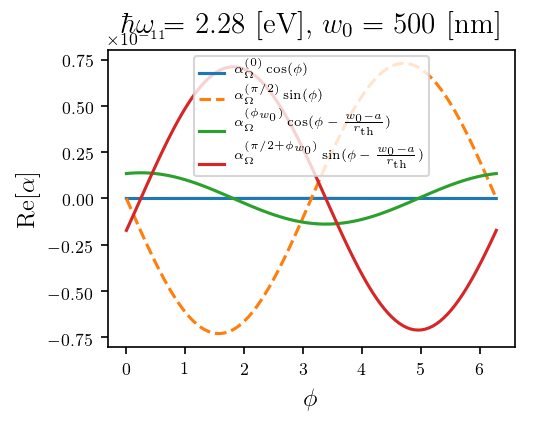

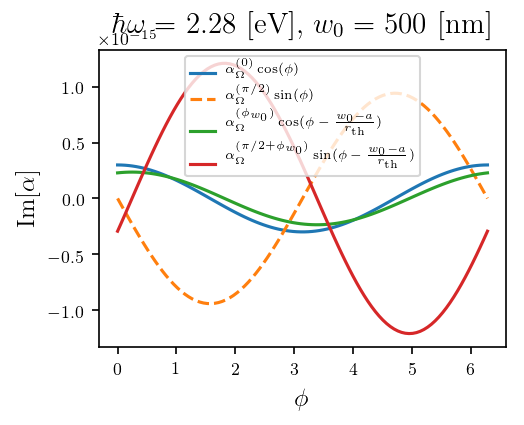

In [41]:
hw = 2.284

build_phase_plots(hw, w0, r_th)

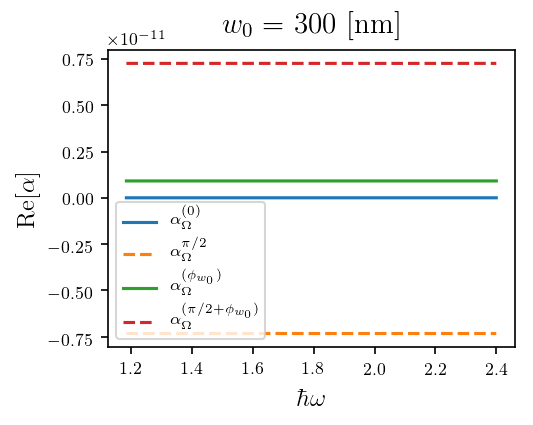

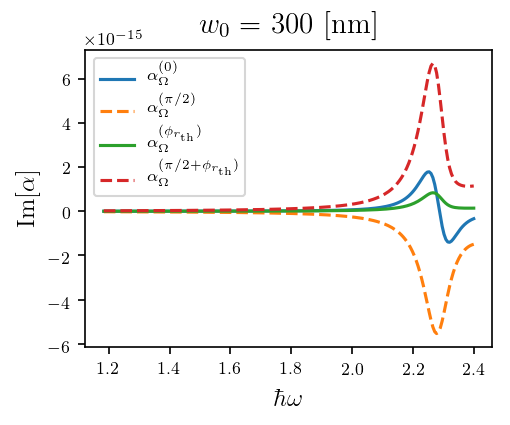

In [42]:
w0 = 300*1e-7

T_expansion = 0

a = 10e-7
r_th = 2e-4

build_mag_plots(T_expansion=T_expansion, r_th=r_th, w0=w0)

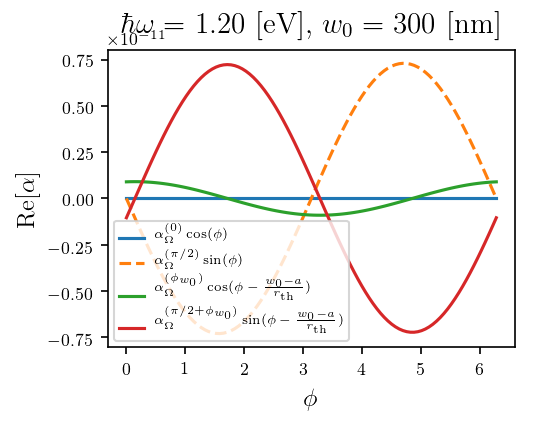

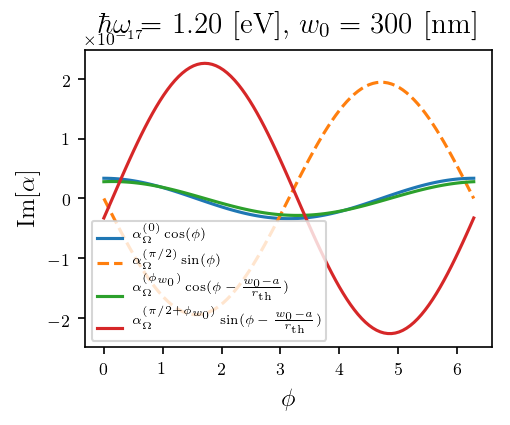

In [43]:
hw = 1.2 

build_phase_plots(hw, w0, r_th)

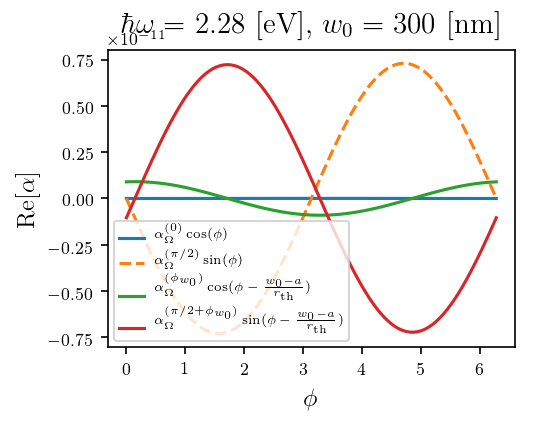

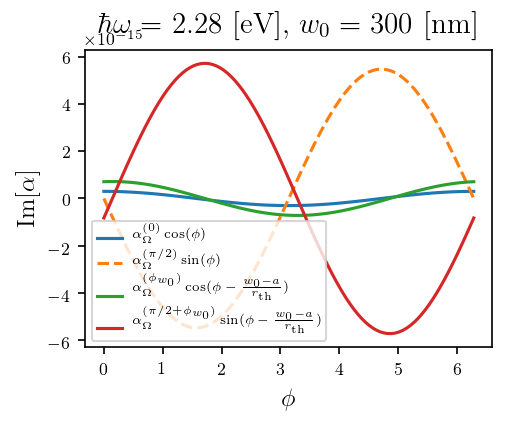

In [44]:
hw = 2.284

build_phase_plots(hw, w0, r_th)

In [45]:
def alpha_static(eps_c, eps_b, a, b, r_th, dndT_c):
    """ Assuming P_abs = 8 * kappa """
    
    dndT_b = -2.7*10**(-4)
    
    alpha = (
        a**3. 
        *
        (eps_c - eps_b)/(eps_c+2*eps_b)
        +
        6*a**3. 
        *
        eps_b/(eps_c+2*eps_b)**2.
        *
        eps_c**0.5
        *
        dndT_c
        *
        (1/(np.pi*a))
        *
        +
        (
            (
                1
                + 
                ((2*a**3./b**3.)
                *
                (eps_c - eps_b)**2./(eps_c+2*eps_b)**2.)
                )
            *
            eps_b**(-0.5)
            *
            dndT_b
            *
            (b**2. - a**2.)
            )
        )
    return alpha

In [46]:
def build_term2_phase_plots(phi, w0, r_th, T_expansion=0):
    fit_drude = cp.drude_lorentz_model(
            hws/hbar, 
            *temp_dep_eps_fits[f'{T_expansion:d}K']['x']
            )
    fit_dndT = dnr_dt_array[:, T_expansion] + 1j*dni_dt_array[:, T_expansion]
    
    plt.plot(
        hws,
        np.real(
            np.conj(alpha_static(
                fit_drude, 
                eps_b=eps_back, 
                a=a, 
                b=w0, 
                r_th=r_th, 
                dndT_c=fit_dndT
                ))
            *
            np.cos(phi) 
            * 
            alpha_0(
                fit_drude, 
                eps_back, 
                a=a, 
                b=w0, 
                r_th=r_th, 
                dndT_c=fit_dndT
                )
            ),
        label=r"$\mathrm{Re}[\alpha_0^* \alpha_\Omega^{(0)}\cos(\phi)]$")
    plt.plot(
        hws,
        np.real(
            np.conj(alpha_static(
                fit_drude, 
                eps_b=eps_back, 
                a=a, 
                b=w0, 
                r_th=r_th, 
                dndT_c=fit_dndT
                ))
            *
            np.sin(phi) 
            * 
            alpha_pion2(
                fit_drude, 
                eps_back, 
                a=a, 
                b=w0, 
                r_th=r_th, 
                dndT_c=fit_dndT
                )
            ),
        label=r"$\mathrm{Re}[\alpha_0^* \alpha_\Omega^{(\pi/2)}\sin(\phi)]$",
        ls='--')
    plt.plot(
        hws,
        np.real(
            np.conj(alpha_static(
                fit_drude, 
                eps_b=eps_back, 
                a=a, 
                b=w0, 
                r_th=r_th, 
                dndT_c=fit_dndT
                ))
            *
            np.cos(phi- (w0-a)/r_th) 
            * 
            alpha_phi(
                fit_drude, 
                eps_back, 
                a=a, 
                b=w0, 
                r_th=r_th, 
                dndT_c=fit_dndT
                )
            ),
        label=r"$\mathrm{Re}[\alpha_0^* \alpha_\Omega^{(\phi_{w_0})}\cos(\phi-\frac{w_0-a}{r_\mathrm{th}})]$")
    plt.plot(
        hws,
        np.real(
            np.conj(alpha_static(
                fit_drude, 
                eps_b=eps_back, 
                a=a, 
                b=w0, 
                r_th=r_th, 
                dndT_c=fit_dndT
                ))
            *
            np.sin(phi - (w0-a)/r_th) 
            * 
            alpha_pion2phi(
                fit_drude, 
                eps_back, 
                a=a, 
                b=w0, 
                r_th=r_th, 
                dndT_c=fit_dndT
                )
            ),
        label=r"$\mathrm{Re}[\alpha_0^* \alpha_\Omega^{(\pi/2+\phi_{w_0})}\sin(\phi-\frac{w_0-a}{r_\mathrm{th}})]$")
    plt.legend(fontsize=6)
    plt.ylabel(r'$I_\mathrm{PT}$')
    plt.xlabel(r'$\hbar\omega$')
    plt.title(r'$\phi =$'+f' {phi:.2f},'+r' $w_0 =$'+f' {round(w0*1e7):d} [nm]')



/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


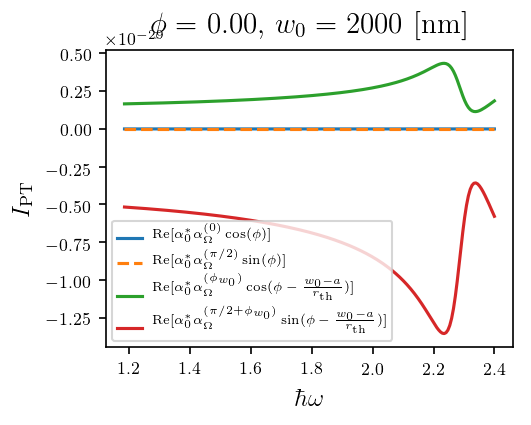

In [47]:
T_expansion = 0

a = 10e-7
r_th = 2e-4

w0 = r_th

build_term2_phase_plots(phi=0, w0=w0, r_th=r_th, T_expansion=0)

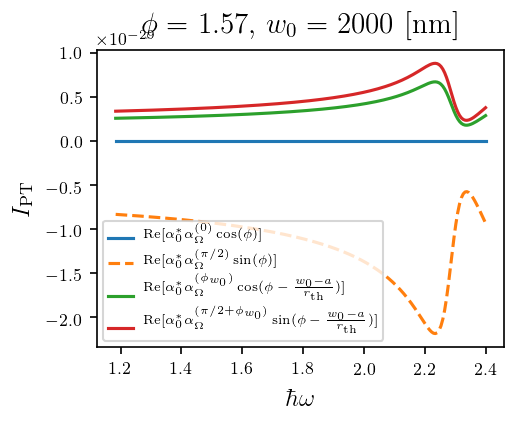

In [48]:
T_expansion = 0

a = 10e-7
r_th = 2e-4

w0 = r_th

build_term2_phase_plots(phi=np.pi/2, w0=w0, r_th=r_th, T_expansion=0)

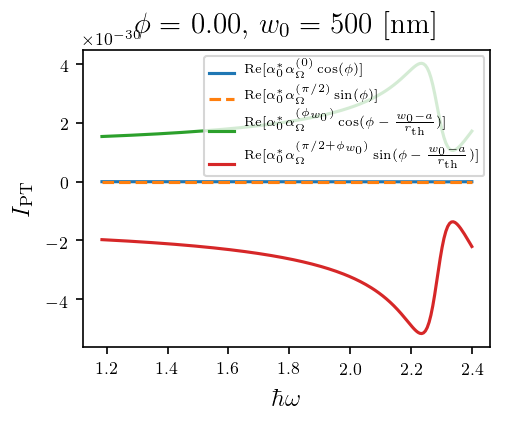

In [49]:
T_expansion = 0

a = 10e-7
r_th = 2e-4

w0 = 500e-7

build_term2_phase_plots(phi=0, w0=w0, r_th=r_th, T_expansion=0)

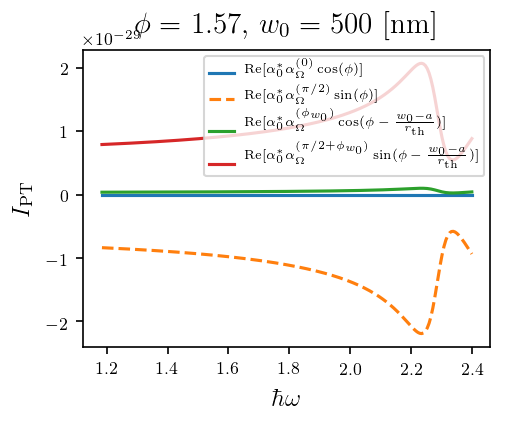

In [50]:
build_term2_phase_plots(phi=np.pi/2, w0=w0, r_th=r_th, T_expansion=0)